# Demo of <tt>TimeSeries</tt> software package

<tt>TimeSeries</tt> calculates standard periodograms and Welch's power spectrum estimates with optional bootstrap false alarm thresholds. The software can also perform Siegel's test for compound periodicity and calculate the spectral window of a periodogram / Welch's estimator. Plotting utilities for both the time series and the periodograms are included. This notebook demonstrates the functionality of the <tt>TimeSeries</tt> class.

### Set up <tt>python</tt> environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from NWelch.TimeSeries import TimeSeries, KaiserBessel

### Read in the demo dataset

These are the Barnard's star activity indicators reported by <a href="https://ui.adsabs.harvard.edu/abs/2019MNRAS.488.5145T/abstract">Toledo-Padron et al. (2019)</a>. Not every activity indicator was measured from every spectrum, so there are some NaNs in the dataset. Columns labeled <tt>nothing1</tt>, <tt>nothing2</tt>, etc. are artifacts of converting a PDF table into a machine-readable format. You can ignore those columns.

In [2]:
specdata = pd.read_csv('Barnard_spec_TP19.csv')
specdata['BJD'] = specdata['BJD-2450000'] + 2450000
specdata

,BJD-2450000,Ha,eHa,nothing1,Ca,nothing2,eCa,nothing3,NaD,eNaD,FWHM,eFWHM,Ins,BJD
0,2743.3873,0.4754,0.0019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UVES,2.452743e+06
1,2763.3957,0.4959,0.0012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UVES,2.452763e+06
2,2804.1585,0.4814,0.0018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UVES,2.452804e+06
3,2839.0807,0.5003,0.0016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UVES,2.452839e+06
4,3082.3893,0.4763,0.0016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UVES,2.453082e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,8034.3570,0.4678,0.0013,NaN,4.349,NaN,0.027,NaN,0.207,0.01,4.520401,0.000063,HARPSN,2.458034e+06
644,8035.3551,0.4693,0.0013,NaN,4.223,NaN,0.026,NaN,0.202,0.01,4.518761,0.000063,HARPSN,2.458035e+06
645,8036.3841,0.4610,0.0014,NaN,3.869,NaN,0.073,NaN,0.201,0.01,4.522845,0.000067,HARPSN,2.458036e+06
646,8037.3360,0.4640,0.0014,NaN,3.736,NaN,0.029,NaN,0.197,0.01,4.516856,0.000065,HARPSN,2.458037e+06


### Create a <tt>TimeSeries</tt> object for the H$\alpha$ data

Syntax: <tt>ts = TimeSeries.TimeSeries(time, observations)</tt>

The constructor will output various estimates of the Nyquist-like frequency, which is the highest frequency about which your data contain reliable information. I say "Nyquist-like" because formally <a href="https://ui.adsabs.harvard.edu/abs/2018ApJS..236...16V/abstract">there is no Nyquist frequency for unevenly-spaced data</a>, but it still makes sense to think carefully about the information content of your time series. The Rayleigh resolution is the lowest frequency about which your time series contains information. 2 x Rayleigh is the minimum spacing of two resolved peaks in the periodogram.

If your dataset is in a <tt>pandas DataFrame</tt>, you have to use the <tt>.to_numpy()</tt> function when you construct the <tt>TimeSeries</tt> object. 

In [3]:
good_ha = specdata['Ha'].notna() # find all the valid H-alpha measurements
ha = TimeSeries(specdata['BJD'][good_ha].to_numpy(), 
                specdata['Ha'][good_ha].to_numpy())

Nyquist frequency from mean dt: 0.05760
Nyquist frequency from 10% trimmed mean dt: 0.13201
Nyquist frequency from 20% trimmed mean dt: 0.18904
Nyquist frequency from median dt: 0.48731
Rayleigh resolution: 0.00019


### Plot the H$\alpha$ data

You can use the <tt>xlabel</tt> and <tt>ylabel</tt> keywords to set your plot labels, or the software will apply generic labels.

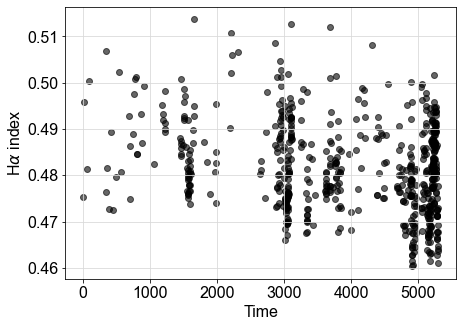

In [4]:
ha.scatterplot(ylabel=r"H$\alpha$ index")

### Plot the $\Delta t$ histogram

$\Delta t_i = t_{i+1} - t_i$. Some RV datasets are very unevenly spaced, with $\Delta t$ distributions spanning $> 6$ orders of magnitude. Examining the $\Delta t$ histogram can help you choose a sensible Nyquist-like frequency for your periodograms. You can set the number of bins with the <tt>nbins</tt> keywond, or accept the default <tt>nbins=10</tt>.

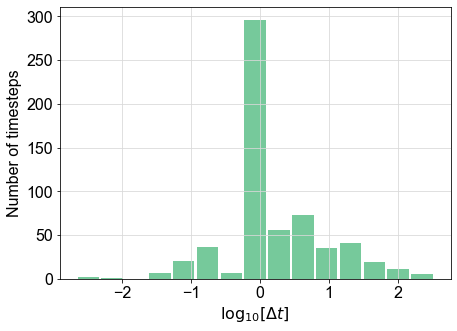

In [5]:
ha.dthist(nbins=15)

### Construct a frequency grid for the Lomb-Scargle periodogram

Unlike <tt>astropy.TimeSeries.LombScargle</tt>, this software separates frequency-grid construction and periodogram calculation into two different functions. This is so the user has to make a conscious decision about which frequencies it makes sense to probe. Syntax is

<tt>ts.frequency_grid(Nyquist, oversample=4)</tt>

<tt>Nyquist</tt> is the maximum frequency in the grid, and <tt>oversample</tt> is the number of gridpoints per Rayleigh resolution. You can leave out the <tt>oversample</tt> keyword to accept the default of 4 gridpoints per Rayleigh. You can choose any positive number for the Nyquist-like frequency, but the code will print a warning if you set <tt>Nyquist > 1 / median(dt)</tt>.

In [6]:
ha.frequency_grid(0.2, oversample=5)

### Calculate the complex-valued Fourier transform and the Lomb-Scargle-like periodogram

This periodogram is Lomb-Scargle-like because it's computed with a non-uniform FFT, not with the actual Lomb-Scargle algorithm. We use the non-uniform FFT because we need the complex-valued FFT for coherence calculations. Feel free to test <tt>pow_FT()</tt> against <tt>astropy.TimeSeries.LombScargle</tt>; see a comparison between the two methods in the accompanying paper (Figure 21). Syntax:

<tt>ts.pow_FT(window='None', trend=True, trend_type='linear', N_bootstrap=10000, norm=True, save_noise=False, quiet=False)</tt>

With the <tt>window</tt> keyword, you can choose whether to multiply the data by a window before taking the FFT. Choices are <tt>'None', 'BlackmanHarris',</tt> or <tt>'KaiserBessel'</tt>. Your periodogram will look less noisy if you use either the Blackman-Harris or the Kaiser-Bessel window, but if there's high-cadence data either at the very beginning or the very end of the time series, windowing will lose you a lot of information. We will create both windowed and non-windowed periodograms of the Barnard's star H$\alpha$ data so you can see the difference.

With the <tt>trend</tt> keyword, you can choose whether or not to subtract out a linear trend before taking the FFT. The default is to detrend; set <tt>trend=False</tt> to turn off detrending. You can also do quadratic detrending by setting <tt>trend_type='quadratic'</tt>. This functionality is relatively untested. We think it could be useful when a segment contains a long-term nonlinear trend; those trends should land in the zero-frequency power spectrum bin, but in reality they leak power into higher frequencies and bias the power spectrum estimate. However, we haven't done any rigorous statistical analysis on quadratic detrending, and it could remove real signal. Use at your own risk. There's a demo of quadratic detrending in the <tt>aCenB/</tt> directory.

<tt>N_bootstrap</tt> is the number of bootstrap iterations used to calculate false alarm thresholds. Set <tt>N_bootstrap</tt> $< 100$ to turn off the bootstrap calculation.

The <tt>norm</tt> keyword allows you to choose whether or not to use Parseval's theorem to normalize your power spectrum. Parseval's theorem states that ${\rm Var} [x_t] = \left( \sum_{f=0}^{f_{\rm Nyq}} |X(f)|^2 \Delta f \right) / f_{\rm Nyq}$, where $X(f)$ is the Fourier transform of $x_t$ and $\Delta f$ is the spacing of your frequency grid. The only reason not to normalize is if you're using <tt>pow_FT</tt> as part of a more complex calculation that calls for a different normalization (i.e. coherence).

If want to examine the output of the bootstrap simulation, you can set <tt>save_noise=True</tt>. The array containing the power of the highest peak from each bootstrap iteration will saved to <tt>ts.frequency_domain_noise</tt>.

Set <tt>quiet=True</tt> to stop the function from printing out the bootstrap progress.

#### First the un-tapered periodogram (rectangular spectral window)

In [7]:
ha.pow_FT()

Iteration 0
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
Iteration 3000
Iteration 3500
Iteration 4000
Iteration 4500
Iteration 5000
Iteration 5500
Iteration 6000
Iteration 6500
Iteration 7000
Iteration 7500
Iteration 8000
Iteration 8500
Iteration 9000
Iteration 9500


### Plot the periodogram / power spectrum estimate

Syntax: <tt>ts.powplot(show_thresholds=True, Welch=False, yscale='log10', title='', vlines=[], lw=0.8)</tt>

The default is to show the bootstrap false alarm thresholds on the plot. If you don't want to show the false alarm thresholds, set <tt>show_thresholds=False</tt>.

If you want to plot a Welch's power spectrum estimate, set <tt>Welch=True</tt>. Default is to plot the Lomb-Scargle-like periodogram.

The default y-axis scale is logarithmic. There are lots of good reasons for this:
<ul>
    <li>Power spectrum peaks that aren't significant when judged against a white noise model can correspond to coherence peaks that ARE significant, so it's good to be able to see all the local maxima in the power spectrum (see the alpha Cen B analysis in section 4.2 of the accompanying paper)</li>
    <li>Human vision and hearing respond on a log scale</li>
    <li>Engineering processes often involve linear filters, for example a simple moving average applied to data is  obvious when looking at the power spectrum on a logarithmic y-axis because you can actually visualize the sidelobes of such a filter</li>
</ul>
However, if you must, you can set <tt>yscale='linear'</tt> for a linear scale on the y-axis. Both axes scales are shown below.

Use the <tt>title</tt> keyword to customize the title of your plot.

Add vertical lines to the plot using the <tt>vlines</tt> keyword. The argument must be a list. Here we will add a vertical line at the star's rotation frequency.

Change the linewidth with the <tt>lw</tt> keyword.

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


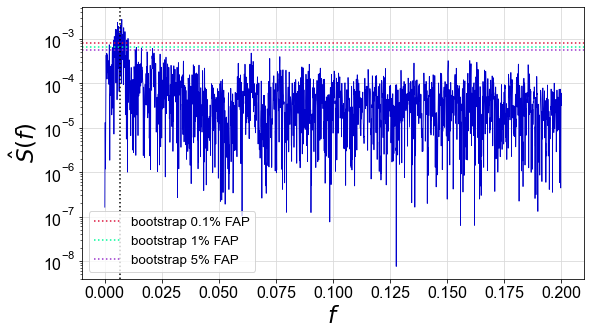

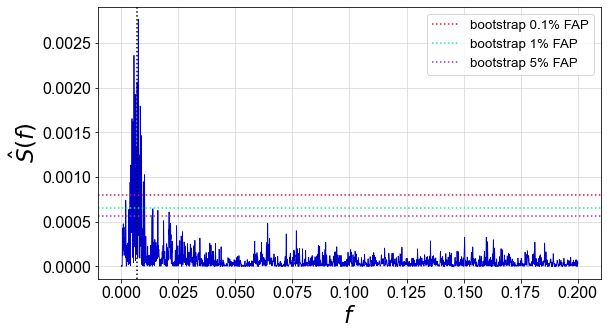

In [8]:
frot = 1/145 # Rotation period is 145 days, according to Toledo-Padron et al. (2019)
ha.powplot(vlines=[frot])
ha.powplot(vlines=[frot], yscale='linear')

Rotation generates a strong signal in the H$\alpha$ periodogram, and the peak associated with it is very wide, as we might expect for a quasiperiodic signal.

### Plot the complex-valued Fourier transform of the H$\alpha$ time series

It's sometimes useful to plot the FT if, for example, you're trying to examine the relative phase of two signals in the same time series, or the same signal in two different time series.

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


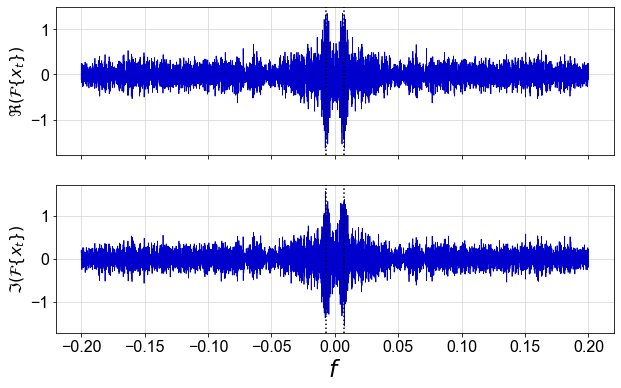

In [9]:
ha.Ftplot(vlines=[frot])

#### Return the complex-valued Fourier coefficients and periodogram in dictionary form

Useful if you want to work with them outside of NWelch. Frequency grid for Fourier coefficients is symmetric about zero so that it includes negative frequencies.

In [10]:
ha_pgram = ha.get_periodogram()
ha_FT = ha.get_Fourier()

print(ha_pgram)
print(ha_FT)

{'frequency': array([0.00000000e+00, 3.77786173e-05, 7.55572346e-05, ...,
       1.99924443e-01, 1.99962221e-01, 2.00000000e-01]), 'periodogram': array([3.37264679e-16, 4.44634983e-09, 1.62390758e-07, ...,
       6.02521425e-05, 4.70181375e-05, 3.15945920e-05])}
{'frequency_symmetric': array([-0.2       , -0.19996222, -0.19992444, ...,  0.19992444,
        0.19996222,  0.2       ]), 'Fourier_coeffs': array([-0.11164005+0.14329407j,  0.09693348+0.19927017j,
        0.24734126+0.04181274j, ...,  0.24734126-0.04181274j,
        0.09693348-0.19927017j, -0.11164005-0.14329407j])}


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Repeat the periodogram calculation, but this time use a Kaiser-Bessel window

In [11]:
ha.pow_FT(window='KaiserBessel')

Iteration 0
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
Iteration 3000
Iteration 3500
Iteration 4000
Iteration 4500
Iteration 5000
Iteration 5500
Iteration 6000
Iteration 6500
Iteration 7000
Iteration 7500
Iteration 8000
Iteration 8500
Iteration 9000
Iteration 9500


### Plot the periodogram and FT of the Kaiser Bessel-windowed H$\alpha$ time series

Vertical lines on the periodogram show the rotation frequency, the first rotation harmonic ($2 \times f_{\rm rot}$), and the third rotation harmonic ($4 \times f_{\rm rot}$). There may be a peak associated with the third harmonic in the windowed periodogram, or perhaps the power deficit between $2 f_{\rm rot}$ and $4 f_{\rm rot}$ that creates the appearance of a peak at $4 f_{\rm rot}$ is an undesirable artifact of the widowing. A lot of the observations were taken at very high cadence near the end of the time series, and the window will nearly zero out those observations. It's often hard to decide whether to use a window.

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


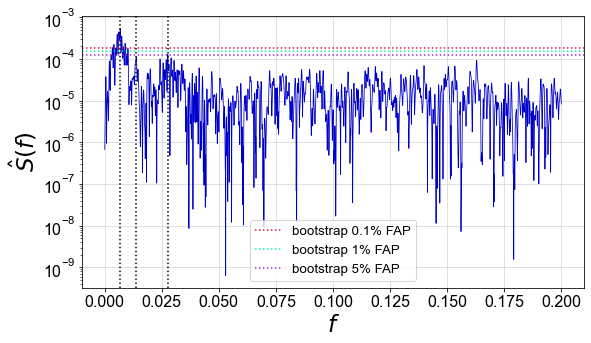

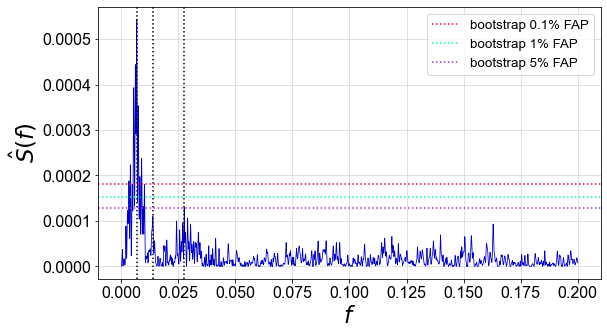

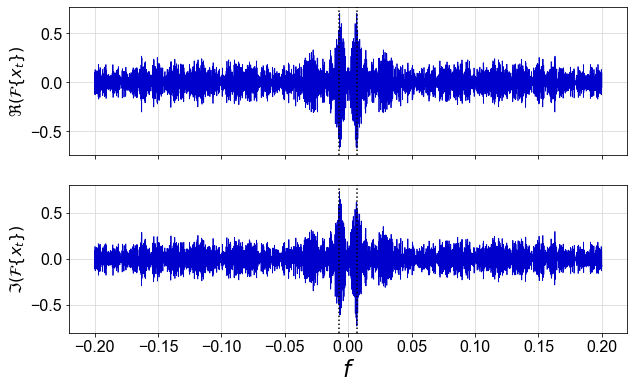

In [12]:
ha.powplot(vlines=[frot, 2*frot, 4*frot])
ha.powplot(vlines=[frot, 2*frot, 4*frot], yscale='linear')
ha.Ftplot(vlines=[frot])

### Visualize the Kaiser-Bessel window

All variables and functions in the <tt>TimeSeries</tt> class are publicly accessible, so you can peek "under the hood" anywhere you like. Here we use the observation times (<tt>ha.t</tt>) and the <tt>KaiserBessel()</tt> function to show what the Kaiser-Bessel window looks like when applied to this dataset.

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


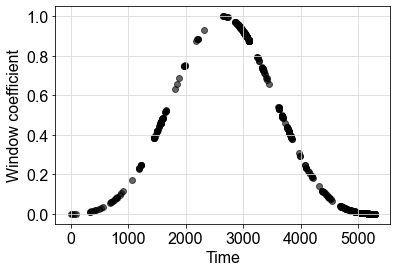

In [13]:
plt.scatter(ha.t, KaiserBessel(ha.t), color='k', alpha=0.6, edgecolor='k')
plt.xlabel('Time')
plt.ylabel('Window coefficient')
plt.grid(color='0.85')

### Same visualization, but use <tt>get_window()</tt> to return the window coefficients

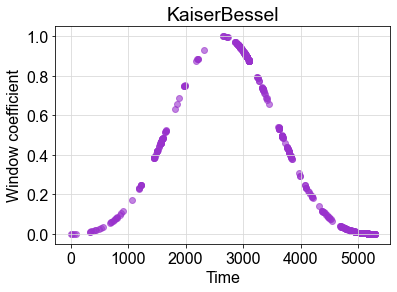

In [14]:
KB_window = ha.get_window()
plt.scatter(ha.t, KB_window['coefficients'], color='darkorchid', alpha=0.6, 
            edgecolor='darkorchid')
plt.xlabel('Time')
plt.ylabel('Window coefficient')
plt.title(KB_window['window_type'])
plt.grid(color='0.85')

### Segment the data in preparation for Welch's algorithm

Here we will break the data into overlapping segments, set up the frequency grid for the Welch's periodogram, and choose a windowing scheme. The syntax is

<tt>ts.segment_data(seg, Nyquist, oversample=6, window='None', plot_windows=False, quiet=False)</tt>

<tt>seg</tt> is either the integer number of 50% overlapping segments you would like to use, OR a 2-d <tt>numpy</tt> array specifying the starting and ending point of each segment. A good reason to set the segment start and end points by hand is to work around large gaps; it's best to avoid having a big gap in the middle of a segment.

<tt>Nyquist</tt> is the maximum frequency in your grid. Since each Welch's segment will have a different $\Delta t$ distribution, and therefore different frequency coverage, the code warn you if your Nyquist-like frequency is higher than $1/\operatorname{median}(\Delta t)$ of the most sparsely sampled segment.

Set the <tt>oversample</tt> keyword to control the number of grid points per Rayleigh resolution. Here the Rayleigh resolution is set by the duration of the longest segment, <em>not</em> the duration of the entire time series as in <tt>frequency_grid()</tt> above.

Use the <tt>window</tt> keyword to choose among rectangular, Blackman-Harris, and Kaiser-Bessel windows (<tt>'None', 'BlackmanHarris', 'KaiserBessel'</tt>). Your choice of window will be applied <em>to each segment</em>. Windowing the segments will reduce the variance in your Welch's power spectrum estimate, but it can also give weird results if the time sampling is extremely uneven.

Set <tt>plot_windows=True</tt> to see what the windows look like. Since <tt>TimeSeries</tt> shifts each segment so it starts at $t = 0$, all the windows will start at time zero in the plot. They will almost always have different durations. The windows should have bell-like shapes. If big chunks of any "bell" are missing, you could get strange results from the windowing. In that case, use fewer segments so each window is better sampled or set <tt>window='None'</tt>.

The software has a hard lower limit of 29 data points per segment. A statistically sensible hard lower limit is more like 50 data points per segment (see section 3.4 of the accompanying paper), and we highly recommend $> 100$ data points per segment. I allowed 29 here just so the user can construct a "first-look" Welch's power spectrum of a preliminary dataset, but I don't endorse using the software that way.

By default the software will print out information about the number of data points per segment, spectral window half lobe width estimates, and power spectrum resolution. Set <tt>quiet=True</tt> to suppress output.

Number of data points per segment: 203
Number of segments: 5
Segment start and end points: [[  0 203]
 [101 304]
 [203 406]
 [304 507]
 [405 611]]
Effective number of segments: 4.988475
Frequency grid spacing: 0.000054
Minimum 6-dB main lobe half width: 0.000877
Mean 6-dB main lobe half width (1/2 resolution limit): 0.003591
Best achievable Rayleigh limit (1/2 best-case resolution limit): 0.000322


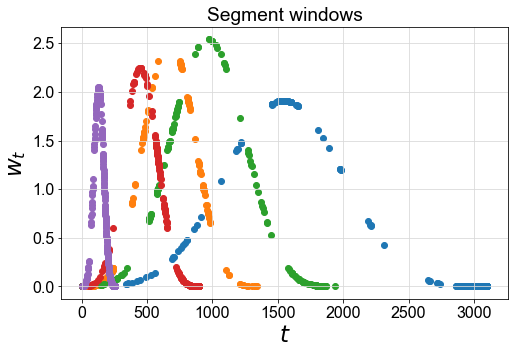

In [15]:
ha.segment_data(5, 0.2, window='BlackmanHarris', plot_windows=True)

These windows look pretty good. The bell shapes are easily recognizable.

#### Return the segment boundaries (useful if they were computed automatically by NWelch)

Tells you the segment boundaries and the effective number of segments, as corrected for overlap

In [16]:
print(ha.get_segments())

{'segment_bounds': array([[  0, 203],
       [101, 304],
       [203, 406],
       [304, 507],
       [405, 611]]), 'effective_number': 4.988474628218962}


### Compute the Welch's power spectrum estimate

Syntax: <tt>ts.Welch_powspec(trend=True, trend_type='linear', norm=True, mode='mean')</tt>

Setting <tt>trend=True</tt> (default) will subtract a linear trend from <em>each</em> Welch's segment prior to computing its periodogram. I generally do the linear segment detrending, as it helps suppress spectral leakage. As in the Lomb Scargle-like periodogram, you can set <tt>trend_type='quadratic'</tt> at your own risk.

Keep the default <tt>norm=True</tt> to normalize the Welch's periodogram using Parseval's theorem. Unless you want to use your Welch's power spectrum in a further calculation that demands a different normalization, there's no good reason to turn off the normalization.

The default <tt>mode='mean'</tt> keyword computes the power spectrum estimate by taking the mean of the individual segment estimates. <tt>mode='median'</tt> uses the median of the segment estimates, which sometimes produces false alarm levels that are more in line with what we see from the simple Lomb-Scargle-like periodogram. Thanks to Victor Ramirez Delgado for suggesting a median-combine mode.

In [17]:
ha.Welch_powspec()

#### Return the Welch's power spectrum estimate as a dictionary of {frequency, Welch_power}

Useful if you want to work with it outside of NWelch

In [18]:
print(ha.get_Welch())

{'frequency': array([0.00000000e+00, 5.37634409e-05, 1.07526882e-04, ...,
       1.99892473e-01, 1.99946237e-01, 2.00000000e-01]), 'Welch_power': array([2.60295460e-04, 2.60692879e-04, 2.61890323e-04, ...,
       1.25163333e-05, 1.54911423e-05, 1.90471789e-05])}


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Compute bootstrap false alarm levels for the Welch's power spectrum estimate

Syntax: <tt>ts.Welch_powspec_bootstrap(N_Welch_bootstrap=10000, save_noise=False)</tt>

Use the keyword <tt>N_Welch_bootstrap</tt> to change the number of bootstrap iterations. A valid bootstrap simulation requires <tt>N_Welch_bootstrap > 100</tt>.

Set <tt>save_noise=True</tt> to save an array containing the power level of the highest peak in each bootstrap power spectrum estimate (useful if you want to examine the noise properties in detail). The array will be saved to <tt>ts.Welch_noise</tt>.

In [19]:
ha.Welch_powspec_bootstrap()

Iteration 0
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
Iteration 3000
Iteration 3500
Iteration 4000
Iteration 4500
Iteration 5000
Iteration 5500
Iteration 6000
Iteration 6500
Iteration 7000
Iteration 7500
Iteration 8000
Iteration 8500
Iteration 9000
Iteration 9500


### Plot the Welch's power spectrum estimate

Use <tt>powplot()</tt> again, but set <tt>Welch=True</tt>.

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


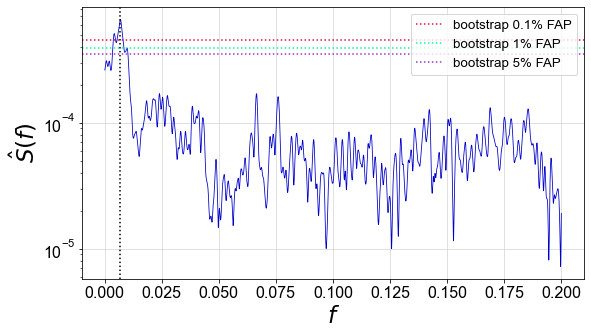

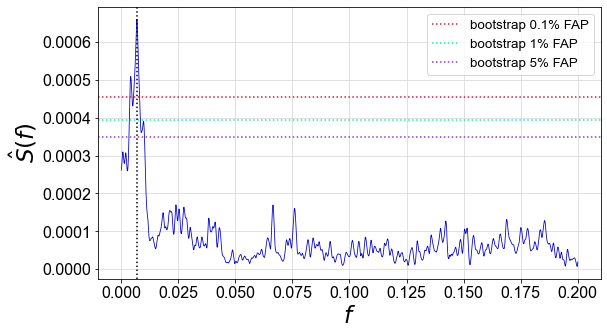

In [20]:
ha.powplot(Welch=True, vlines=[frot])
ha.powplot(Welch=True, vlines=[frot], yscale='linear')

Here we see the noise suppression capability of Welch's algorithm. The published rotation period matches up well with the highest peak in the Welch's periodogram. The possible signal at the 3rd rotation harmonic is gone, however.

### Repeat the Welch's power spectrum estimate, this time using the median of the individual segment estimates

In [ ]:
ha.Welch_powspec(mode='median')
ha.Welch_powspec_bootstrap()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Iteration 0
Iteration 500
Iteration 1000
Iteration 1500


It's a good idea to put the plot in a different cell from the actual calculation. That way if you want to tweak the plot a little bit, you don't repeat the calculation.

In [ ]:
ha.powplot(Welch=True, vlines=[frot])

### Use Siegel's test to check for periodicity in the H$\alpha$ time series

Both the standard and the Welch's power spectrum estimate show a strong peak at the rotation frequency, so we expect Siegel's test to reject the null hypothesis of a white-noise time series. Here we will apply Siegel's test to both the Welch's power spectrum estimate and the Lomb Scargle-like periodogram from cell 10.

Syntax: <tt>ts.Siegel_test(Welch=False, tri=False)</tt>

Set <tt>Welch=True</tt> to apply the test to the Welch's power spectrum estimate (default is the Lomb-Scargle).

Set <tt>tri=True</tt> to consider up to three periodicities. With <tt>tri=False</tt>, the test could fail to reject the null hypothesis if there are more than two periodic signals. On the other hand, the more conservative version of the test with <tt>tri=False</tt> is less likely to mistake noise for a periodic signal. See section 3.7 of the accompanying paper for more information.

In [ ]:
ha.Siegel_test()
ha.Siegel_test(Welch=True)

### Examine the spectral windows of the periodogram and Welch's estimator

Here we will look at the spectral window in the frequency domain, which is the squared absolute value of the Fourier transform of the window applied in the time domain. The power spectrum estimate is the spectral window convolved with the true power spectrum (see section 3.3, equation 20 of the accompanying paper). In a power spectrum estimate, each periodic signal is a copy of the spectral window.*

Syntax: <tt>spectral_window = ts.spectral_window(plot=True, yscale='log10', outfile="None")</tt> for the spectral window of the Lomb-Scargle-like periodogram, or

<tt>spectral_window_Welch = ts.spectral_window_Welch(plot=True, yscale='log10', outfile="None")</tt> for the spectral window of the Welch's estimator.

Set <tt>outfile="filename.txt"</tt> to write the spectral window to a file. Set <tt>plot=False</tt> if you want to calculate the spectral window, but not plot it. The function returns the spectral window in dictionary form so you can work with it outside of NWelch.

For the spectral window plot, a log y-axis scale is the best option. Both are shown here, but you for sure want to look at the log version so that you can carefully check for sidelobes.

*Though uneven spacing can add a pseudowindow effect; see <a href="https://ui.adsabs.harvard.edu/abs/1982ApJ...263..835S/abstract">Scargle (1982)</a> for more details.

In [ ]:
spectral_window = ha.spectral_window()
spectral_window_Welch = \
         ha.spectral_window_Welch(outfile='Barnard_Halpha_Welch_spectral_window.txt')
_ = ha.spectral_window_Welch(yscale='linear')

<tt>TimeSeries.spectral_window()</tt> and <tt>TimeSeries.spectral_window_Welch()</tt> return the spectral windows so you can examine them outside of <tt>NWelch</tt>

In [ ]:
print(spectral_window)
print(spectral_window_Welch)

### Save the periodogram and Welch's power spectrum estimate

Syntax: <tt>ts.save_standard(filename)</tt> to save the Lomb-Scargle-like periodogram, or <tt>ts.save_Welch(filename)</tt> to save the Welch's power spectrum estimate. Output is a .csv file. The file header will contain information about windowing, detrending, Rayleigh resolution, bootstrap false alarm thresholds, and for Welch's algorithm, the segmenting scheme.

In [ ]:
ha.save_standard('Barnard_Halpha_standard_periodogram.csv')
ha.save_Welch('Barnard_Halpha_Welch_periodogram.csv')